# Introduction

This work presents a constrained combinatorial optimization approach to the **Sports League Assignment Problem** using **Genetic Algorithms (GAs)**. The objective is to allocate a fixed pool of professional players into a set of 5 structurally valid teams in such a way that the **standard deviation of the teams\' average skill ratings** is minimized—promoting competitive balance across the league.

Each player is defined by three attributes: **position** (one of `GK`, `DEF`, `MID`, `FWD`), **skill rating** (a numerical measure of ability), and **cost** (in million euros). A valid solution must satisfy the following **hard constraints**:

- Each team must consist of exactly **7 players**, with a specific positional structure: **1 GK, 2 DEF, 2 MID, and 2 FWD**
- Each team must have a **total cost ≤ 750 million €**
- Each player must be assigned to **exactly one team** (no overlaps)

The **search space** is therefore highly constrained and discrete, and infeasible configurations are explicitly excluded from the solution space. The optimization objective is to identify league configurations where teams are not only valid but also **skill-balanced**, quantified by the **standard deviation of average skill ratings across teams**, which serves as the **fitness function** (to be minimized).

To address this, we implement a domain-adapted **Genetic Algorithm framework** featuring:

- A custom **representation** based on team-to-player mappings
- Validity-preserving **mutation** and **crossover** operators
- Multiple **selection mechanisms**
- Optional **elitism** and population-level diversity handling

This report provides a formal problem definition, details the design of the solution encoding and operators, and presents empirical results comparing different GA configurations. The overall objective is to evaluate how well GA-based metaheuristics can navigate this complex constrained search space and evolve solutions that both satisfy domain constraints and optimize league balance.

In addition to Genetic Algorithms, this project also explores and evaluates alternative optimization strategies, such as **Hill Climbing** and **Simulated Annealing**, which are well-suited for navigating discrete and constrained search spaces. These algorithms offer different trade-offs in terms of exploration, exploitation, and convergence speed. By implementing and benchmarking multiple approaches on the same problem, we aim to gain deeper insights into their relative effectiveness and robustness when applied to complex constrained optimization tasks such as the Sports League Assignment. This comparative analysis enhances the interpretability of results and supports a broader understanding of the strengths and limitations of population-based versus local search-based heuristics.

## Cell 1: Setup and Critical Data Loading

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from solution import LeagueSolution, LeagueHillClimbingSolution, LeagueSASolution
from evolution import genetic_algorithm, hill_climbing, simulated_annealing_for_league
from operators import (
    # Base Mutations (examples, can be used for comparison)
    mutate_swap, 
    mutate_team_shift,
    mutate_shuffle_team, 
    # New/Adapted Mutations
    mutate_swap_constrained,
    mutate_targeted_player_exchange,
    mutate_shuffle_within_team_constrained,
    # Base Crossovers (examples, can be used for comparison)
    crossover_one_point,
    crossover_uniform,
    # New/Adapted Crossovers
    crossover_one_point_prefer_valid,
    crossover_uniform_prefer_valid,
    # Base Selections (examples, can be used for comparison)
    selection_ranking,
    # New/Adapted Selections
    selection_tournament_variable_k,
    selection_boltzmann
)

# Load player data
players_df = pd.read_csv("players.csv", sep=";")
players = players_df.to_dict(orient="records")

## Cell 2: Further Setup and Data Inspection

In [2]:
# Define problem parameters (can be centralized here for clarity)
NUM_TEAMS = 5
TEAM_SIZE = 7
MAX_BUDGET = 750

print("Player data loaded successfully.") 
print(f"Total players: {len(players)}")
if players:
    print("First player data:", players[0]) # Print first player to confirm structure
players_df.head()

Player data loaded successfully.
Total players: 35
First player data: {'Unnamed: 0': 0, 'Name': 'Alex Carter', 'Position': 'GK', 'Skill': 85, 'Salary (€M)': 90}


,Unnamed: 0,Name,Position,Skill,Salary (€M)
0,0,Alex Carter,GK,85,90
1,1,Jordan Smith,GK,88,100
2,2,Ryan Mitchell,GK,83,85
3,3,Chris Thompson,GK,80,80
4,4,Blake Henderson,GK,87,95


## Problem Representation Details (from original notebook)

### A. Team-based Representation (Structured Encoding)

Let:

- $P = \{p_1, p_2, \dots, p_{35}\}$ be the set of players  
- $T = \{t_1, t_2, \dots, t_5\}$ be the set of teams

Define the assignment function:

$$
A: P \rightarrow T
$$

such that each player is assigned to exactly one team, and the following constraints are satisfied:

**Team Size:**

$$
\forall t_j \in T,\quad \left|\{p_i \in P \mid A(p_i) = t_j\}\right| = 7
$$

**Positional Requirements:** For each team $t_j \in T$:

$$
\begin{aligned}
&|\{p_i \in P \mid A(p_i) = t_j \land pos(p_i) = \text{GK}\}| = 1 \\\n# &|\{p_i \in P \mid A(p_i) = t_j \land pos(p_i) = \text{DEF}\}| = 2 \\\n# &|\{p_i \in P \mid A(p_i) = t_j \land pos(p_i) = \text{MID}\}| = 2 \\\n# &|\{p_i \in P \mid A(p_i) = t_j \land pos(p_i) = \text{FWD}\}| = 2
\end{aligned}
$$

**Budget Constraint:**

$$
\forall t_j \in T,\quad \sum_{p_i \in P \mid A(p_i) = t_j} cost(p_i) \leq 750
$$

**Objective Function:** Minimize the standard deviation of average team skill:

$$
f(A) = \sigma\left(\left\{\frac{1}{7} \sum_{p_i \in P \mid A(p_i) = t_j} skill(p_i) \,\middle|\, t_j \in T\right\}\right)
$$

### B. Player-assignment Representation (Linear Encoding) - This is what is implemented

Let:

- $P = \{p_1, p_2, \dots, p_{35}\}$ be the set of players  
- $T = \{0, 1, 2, 3, 4\}$ be team IDs

A solution is represented by a vector:

$$
\mathbf{a} = [a_1, a_2, \dots, a_{35}] \in T^{35}
$$

where $a_i$ is the team assignment for player $p_i$.

**Team Definitions:**

$$
P_j = \{p_i \in P \mid a_i = j\}, \quad \forall j \in T
$$

**Constraints:**

$$
|P_j| = 7 \quad \text{and}
$$

$$
\begin{aligned}
&|\{p \in P_j \mid pos(p) = \text{GK}\}| = 1 \\\n# &|\{p \in P_j \mid pos(p) = \text{DEF}\}| = 2 \\\n# &|\{p \in P_j \mid pos(p) = \text{MID}\}| = 2 \\\n# &|\{p \in P_j \mid pos(p) = \text{FWD}\}| = 2 \\\n# &\sum_{p \in P_j} cost(p) \leq 750
\end{aligned}
$$

**Objective Function:**

$$
f(\mathbf{a}) = \sigma\left(\left\{\frac{1}{7} \sum_{p \in P_j} skill(p) \,\middle|\, j \in T\right\}\right)
$$

## 1. Hill Climbing

Running Hill Climbing Algorithm...
Initial HC solution fitness: 0.8916849448187011
Iteration 0: New best fitness = 0.4729412959213412
Iteration 1: New best fitness = 0.2457807219155049


Iteration 2: New best fitness = 0.10690449676496672
Iteration 3: New best fitness = 0.05714285714285552


Iteration 4: No better neighbor found. Stopping.
Hill Climbing finished. Best fitness: 0.05714285714285552
Hill Climbing finished in 0.26 seconds.
Best solution found by Hill Climbing: [1, 2, 3, 0, 4, 0, 0, 1, 2, 1, 3, 4, 4, 2, 0, 2, 1, 4, 0, 3, 0, 4, 0, 4, 3, 1, 2, 1, 4, 3, 3, 3, 1, 2, 2]
Best fitness: 0.05714285714285552


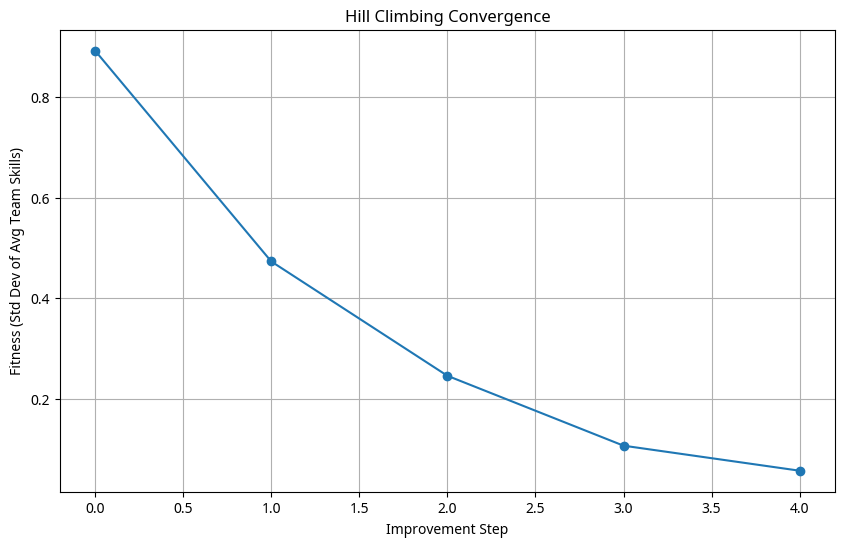

In [3]:
print("Running Hill Climbing Algorithm...")
start_time_hc = time.time()
hc_solution, hc_fitness, hc_history = hill_climbing(players, max_iterations=1000, verbose=True)
end_time_hc = time.time()

print(f"Hill Climbing finished in {end_time_hc - start_time_hc:.2f} seconds.")
if hc_solution:
    print(f"Best solution found by Hill Climbing: {hc_solution.assignment}")
    print(f"Best fitness: {hc_fitness}")
else:
    print("Hill Climbing did not find a valid solution.")

# Plot Hill Climbing History
plt.figure(figsize=(10, 6))
plt.plot(hc_history, marker='o', linestyle='-')
plt.title('Hill Climbing Convergence')
plt.xlabel('Improvement Step')
plt.ylabel('Fitness (Std Dev of Avg Team Skills)')
plt.grid(True)
plt.show()

## 2. Simulated Annealing

Running Simulated Annealing Algorithm...
Initial SA solution fitness: 1.3167678424917635, Temp: 1000


Iter: 500, Temp: 913.52, Current Fitness: 0.5671, Best Fitness: 0.1069
Iter: 1000, Temp: 826.17, Current Fitness: 0.9873, Best Fitness: 0.1069


Iter: 1500, Temp: 747.17, Current Fitness: 1.0857, Best Fitness: 0.1069
Iter: 2000, Temp: 675.73, Current Fitness: 0.4815, Best Fitness: 0.1069


Iter: 2500, Temp: 611.12, Current Fitness: 0.8917, Best Fitness: 0.1069
Iter: 3000, Temp: 552.68, Current Fitness: 1.4009, Best Fitness: 0.1069


Iter: 3500, Temp: 499.84, Current Fitness: 1.3980, Best Fitness: 0.0571
Iter: 4000, Temp: 452.04, Current Fitness: 0.8638, Best Fitness: 0.0571


Iter: 4500, Temp: 408.82, Current Fitness: 1.2269, Best Fitness: 0.0571
Iter: 5000, Temp: 369.73, Current Fitness: 0.8447, Best Fitness: 0.0571


Iter: 5500, Temp: 334.38, Current Fitness: 1.0591, Best Fitness: 0.0571
Iter: 6000, Temp: 302.40, Current Fitness: 0.9790, Best Fitness: 0.0571


Iter: 6500, Temp: 273.49, Current Fitness: 0.7845, Best Fitness: 0.0571
Iter: 7000, Temp: 247.34, Current Fitness: 0.3546, Best Fitness: 0.0571


Iter: 7500, Temp: 223.69, Current Fitness: 1.2758, Best Fitness: 0.0571
Iter: 8000, Temp: 202.30, Current Fitness: 0.6785, Best Fitness: 0.0571


Iter: 8500, Temp: 182.96, Current Fitness: 0.3980, Best Fitness: 0.0571
Iter: 9000, Temp: 165.46, Current Fitness: 1.5712, Best Fitness: 0.0571


Iter: 9500, Temp: 149.64, Current Fitness: 1.1117, Best Fitness: 0.0571
Iter: 10000, Temp: 135.33, Current Fitness: 1.1514, Best Fitness: 0.0571


Iter: 10500, Temp: 122.39, Current Fitness: 1.6522, Best Fitness: 0.0571
Iter: 11000, Temp: 110.69, Current Fitness: 1.2135, Best Fitness: 0.0571


Iter: 11500, Temp: 100.11, Current Fitness: 0.8101, Best Fitness: 0.0571
Iter: 12000, Temp: 90.53, Current Fitness: 0.9407, Best Fitness: 0.0571


Iter: 12500, Temp: 81.88, Current Fitness: 0.7307, Best Fitness: 0.0571
Iter: 13000, Temp: 74.05, Current Fitness: 0.2100, Best Fitness: 0.0571


Iter: 13500, Temp: 66.97, Current Fitness: 0.6963, Best Fitness: 0.0571
Iter: 14000, Temp: 60.56, Current Fitness: 1.2169, Best Fitness: 0.0571


Iter: 14500, Temp: 54.77, Current Fitness: 0.7418, Best Fitness: 0.0571
Iter: 15000, Temp: 49.54, Current Fitness: 1.5344, Best Fitness: 0.0571


Iter: 15500, Temp: 44.80, Current Fitness: 1.0668, Best Fitness: 0.0571
Iter: 16000, Temp: 40.52, Current Fitness: 1.5102, Best Fitness: 0.0571


Iter: 16500, Temp: 36.64, Current Fitness: 1.3474, Best Fitness: 0.0571
Iter: 17000, Temp: 33.14, Current Fitness: 1.1549, Best Fitness: 0.0571


Iter: 17500, Temp: 29.97, Current Fitness: 1.1299, Best Fitness: 0.0571
Iter: 18000, Temp: 27.10, Current Fitness: 0.5813, Best Fitness: 0.0571


Iter: 18500, Temp: 24.51, Current Fitness: 1.1932, Best Fitness: 0.0571
Iter: 19000, Temp: 22.17, Current Fitness: 0.9664, Best Fitness: 0.0571
Iter: 19500, Temp: 20.05, Current Fitness: 0.9143, Best Fitness: 0.0571


Iter: 20000, Temp: 18.13, Current Fitness: 0.4642, Best Fitness: 0.0571
Iter: 20500, Temp: 16.40, Current Fitness: 1.1966, Best Fitness: 0.0571


Iter: 21000, Temp: 14.83, Current Fitness: 0.9320, Best Fitness: 0.0571
Iter: 21500, Temp: 13.41, Current Fitness: 0.7418, Best Fitness: 0.0571


Iter: 22000, Temp: 12.13, Current Fitness: 1.5450, Best Fitness: 0.0571
Iter: 22500, Temp: 10.97, Current Fitness: 1.6645, Best Fitness: 0.0571


Iter: 23000, Temp: 9.92, Current Fitness: 1.0278, Best Fitness: 0.0571
Iter: 23500, Temp: 8.97, Current Fitness: 0.9098, Best Fitness: 0.0571


Iter: 24000, Temp: 8.11, Current Fitness: 0.9363, Best Fitness: 0.0571
Iter: 24500, Temp: 7.34, Current Fitness: 1.3595, Best Fitness: 0.0571


Iter: 25000, Temp: 6.64, Current Fitness: 1.4211, Best Fitness: 0.0571
Iter: 25500, Temp: 6.00, Current Fitness: 0.9536, Best Fitness: 0.0571


Iter: 26000, Temp: 5.43, Current Fitness: 1.1932, Best Fitness: 0.0571
Iter: 26500, Temp: 4.91, Current Fitness: 1.0396, Best Fitness: 0.0571


Iter: 27000, Temp: 4.44, Current Fitness: 0.6540, Best Fitness: 0.0571
Iter: 27500, Temp: 4.02, Current Fitness: 0.9996, Best Fitness: 0.0571


Iter: 28000, Temp: 3.63, Current Fitness: 1.1620, Best Fitness: 0.0571
Iter: 28500, Temp: 3.28, Current Fitness: 0.6020, Best Fitness: 0.0571


Iter: 29000, Temp: 2.97, Current Fitness: 0.7793, Best Fitness: 0.0571
Iter: 29500, Temp: 2.69, Current Fitness: 1.2886, Best Fitness: 0.0571


Iter: 30000, Temp: 2.43, Current Fitness: 0.6414, Best Fitness: 0.0571
Iter: 30500, Temp: 2.20, Current Fitness: 0.2914, Best Fitness: 0.0571


Iter: 31000, Temp: 1.99, Current Fitness: 0.7845, Best Fitness: 0.0571
Iter: 31500, Temp: 1.80, Current Fitness: 1.0782, Best Fitness: 0.0571


Iter: 32000, Temp: 1.63, Current Fitness: 0.4982, Best Fitness: 0.0571
Iter: 32500, Temp: 1.47, Current Fitness: 0.6963, Best Fitness: 0.0571


Iter: 33000, Temp: 1.33, Current Fitness: 0.5299, Best Fitness: 0.0571


Iter: 33500, Temp: 1.20, Current Fitness: 1.4297, Best Fitness: 0.0571
Iter: 34000, Temp: 1.09, Current Fitness: 0.9536, Best Fitness: 0.0571


Iter: 34500, Temp: 0.98, Current Fitness: 0.4554, Best Fitness: 0.0571
Iter: 35000, Temp: 0.89, Current Fitness: 1.4774, Best Fitness: 0.0571


Iter: 35500, Temp: 0.80, Current Fitness: 1.1335, Best Fitness: 0.0571
Iter: 36000, Temp: 0.73, Current Fitness: 1.4269, Best Fitness: 0.0571


Iter: 36500, Temp: 0.66, Current Fitness: 0.7251, Best Fitness: 0.0571
Iter: 37000, Temp: 0.59, Current Fitness: 0.8251, Best Fitness: 0.0571


Iter: 37500, Temp: 0.54, Current Fitness: 1.0077, Best Fitness: 0.0571
Iter: 38000, Temp: 0.49, Current Fitness: 0.4463, Best Fitness: 0.0571


Iter: 38500, Temp: 0.44, Current Fitness: 1.0396, Best Fitness: 0.0571
Iter: 39000, Temp: 0.40, Current Fitness: 0.7635, Best Fitness: 0.0571


Iter: 39500, Temp: 0.36, Current Fitness: 0.9407, Best Fitness: 0.0571
Iter: 40000, Temp: 0.33, Current Fitness: 0.4729, Best Fitness: 0.0571
Iter: 40500, Temp: 0.29, Current Fitness: 0.3546, Best Fitness: 0.0571


Iter: 41000, Temp: 0.27, Current Fitness: 0.2286, Best Fitness: 0.0571
Iter: 41500, Temp: 0.24, Current Fitness: 0.1069, Best Fitness: 0.0571
Iter: 42000, Temp: 0.22, Current Fitness: 0.6602, Best Fitness: 0.0571


Iter: 42500, Temp: 0.20, Current Fitness: 0.8917, Best Fitness: 0.0571
Iter: 43000, Temp: 0.18, Current Fitness: 0.4371, Best Fitness: 0.0571
Iter: 43500, Temp: 0.16, Current Fitness: 0.3307, Best Fitness: 0.0571


Iter: 44000, Temp: 0.15, Current Fitness: 0.2458, Best Fitness: 0.0571
Iter: 44500, Temp: 0.13, Current Fitness: 0.2914, Best Fitness: 0.0571
Iter: 45000, Temp: 0.12, Current Fitness: 0.1666, Best Fitness: 0.0571


Iter: 45500, Temp: 0.11, Current Fitness: 0.1666, Best Fitness: 0.0571
Simulated Annealing finished. Best fitness: 0.05714285714285552
Simulated Annealing finished in 11.45 seconds.
Best solution found by Simulated Annealing: [1, 4, 2, 0, 3, 2, 4, 1, 3, 1, 2, 0, 0, 0, 2, 1, 4, 3, 2, 4, 1, 3, 2, 3, 2, 0, 0, 4, 4, 1, 0, 3, 1, 3, 4]
Best fitness: 0.05714285714285552


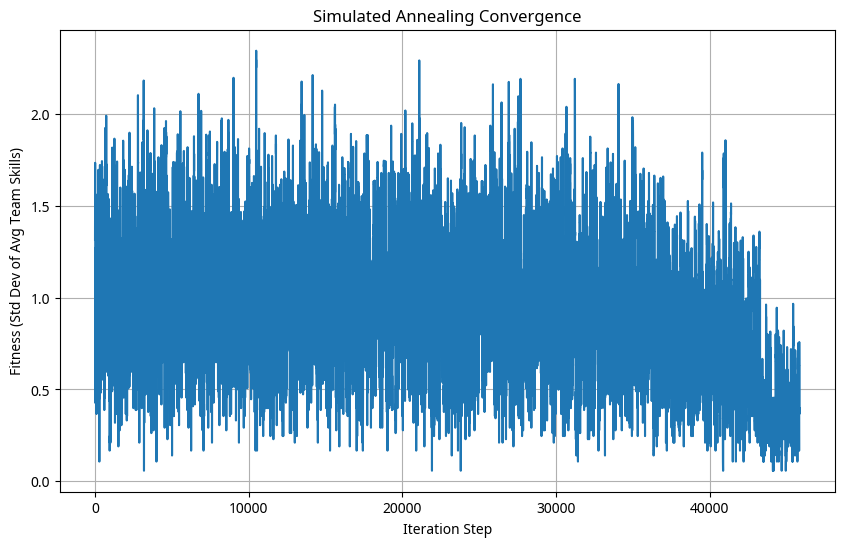

In [4]:
from solution import LeagueSASolution # Ensure this is imported if not already at the top
from evolution import simulated_annealing_for_league # Ensure this is imported

print("Running Simulated Annealing Algorithm...")
start_time_sa = time.time()
# Parameters for SA: initial_temp, final_temp, alpha, iterations_per_temp
sa_solution, sa_fitness, sa_history = simulated_annealing_for_league(
    players,
    initial_temp=1000,
    final_temp=0.1,
    alpha=0.99,
    iterations_per_temp=50, # Number of iterations at each temperature level
    verbose=True
)
end_time_sa = time.time()

print(f"Simulated Annealing finished in {end_time_sa - start_time_sa:.2f} seconds.")
if sa_solution:
    print(f"Best solution found by Simulated Annealing: {sa_solution.assignment}")
    print(f"Best fitness: {sa_fitness}")
else:
    print("Simulated Annealing did not find a valid solution.")

# Plot Simulated Annealing History
plt.figure(figsize=(10, 6))
plt.plot(sa_history, linestyle='-')
plt.title('Simulated Annealing Convergence')
plt.xlabel('Iteration Step')
plt.ylabel('Fitness (Std Dev of Avg Team Skills)')
plt.grid(True)
plt.show()

## 3. Genetic Algorithm with New/Adapted Operators

Now we test the Genetic Algorithm with the newly implemented and adapted operators. We will define several configurations to compare their performance.

Running Genetic Algorithm with NEW/ADAPTED operator configurations...
Running GA_Config_1 (SwapConst,1PtPreferV,TournVarK)...
Error: Initial population is empty. GA cannot proceed.
GA_Config_1 (SwapConst,1PtPreferV,TournVarK) failed to produce a solution.
----------------------------------------------------
Running GA_Config_2 (TargetExch,UnifPreferV,Ranking)...
Error: Initial population is empty. GA cannot proceed.
GA_Config_2 (TargetExch,UnifPreferV,Ranking) failed to produce a solution.
----------------------------------------------------
Running GA_Config_3 (ShuffleWithin,1PtPreferV,Boltzmann)...


Error: Initial population is empty. GA cannot proceed.
GA_Config_3 (ShuffleWithin,1PtPreferV,Boltzmann) failed to produce a solution.
----------------------------------------------------
Running GA_Config_4 (TargetExch,UnifPreferV,TournVarK_k5)...
Error: Initial population is empty. GA cannot proceed.
GA_Config_4 (TargetExch,UnifPreferV,TournVarK_k5) failed to produce a solution.
----------------------------------------------------


/tmp/ipykernel_16943/1366450591.py:86: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='upper right', bbox_to_anchor=(1.5, 1))


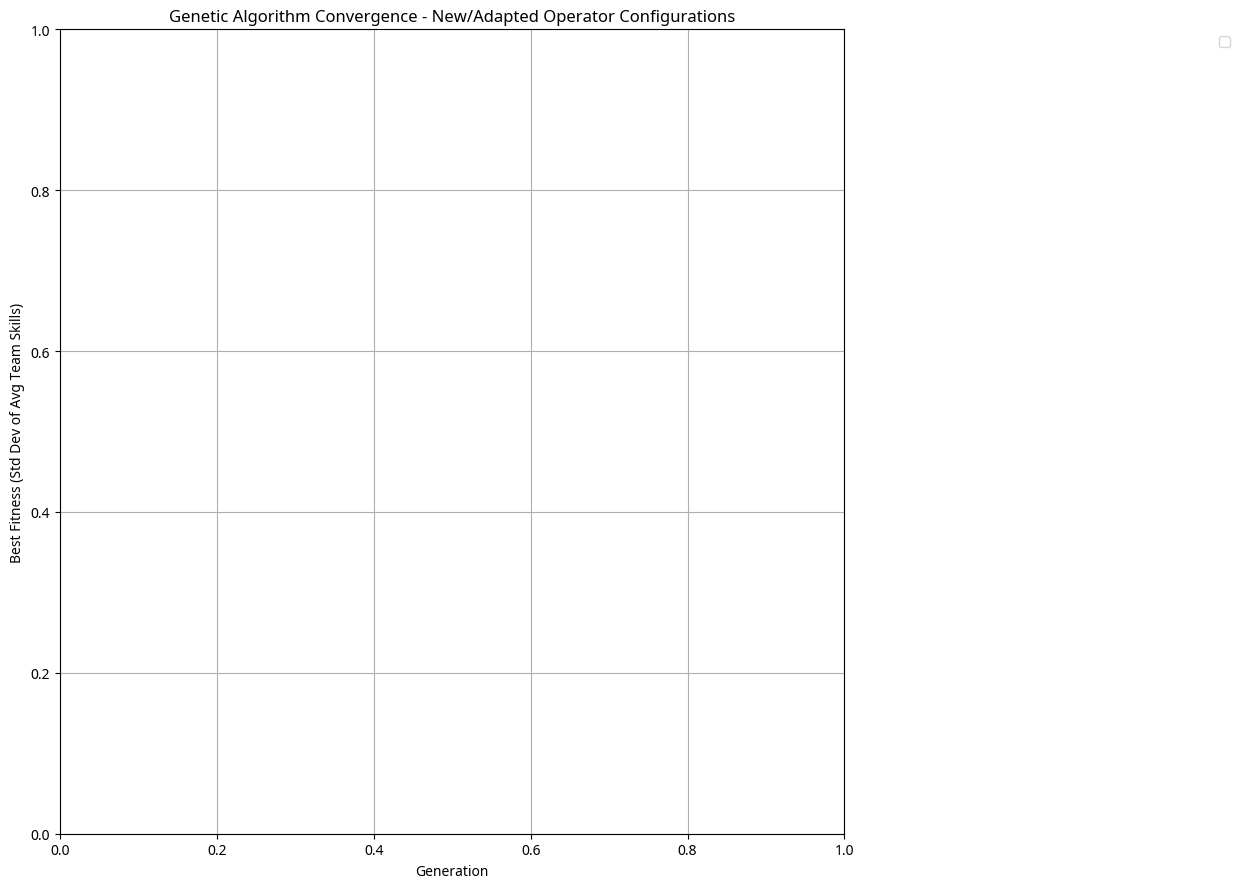


Best Solutions from New GA Configurations:


In [5]:
# Define configurations for GA with new operators
# Each config: (mutation_op, crossover_op, selection_op, tournament_k_if_applicable, boltzmann_temp_if_applicable)
ga_configs_new = [
    {
        "name": "GA_Config_1 (SwapConst,1PtPreferV,TournVarK)",
        "mutation_operator_func": mutate_swap_constrained,
        "crossover_operator_func": crossover_one_point_prefer_valid,
        "selection_operator_func": selection_tournament_variable_k,
        "tournament_k": 3,
        "boltzmann_temp": None # Not used
    },
    {
        "name": "GA_Config_2 (TargetExch,UnifPreferV,Ranking)",
        "mutation_operator_func": mutate_targeted_player_exchange,
        "crossover_operator_func": crossover_uniform_prefer_valid,
        "selection_operator_func": selection_ranking,
        "tournament_k": None, # Not used
        "boltzmann_temp": None # Not used
    },
    {
        "name": "GA_Config_3 (ShuffleWithin,1PtPreferV,Boltzmann)",
        "mutation_operator_func": mutate_shuffle_within_team_constrained,
        "crossover_operator_func": crossover_one_point_prefer_valid,
        "selection_operator_func": selection_boltzmann,
        "tournament_k": None, # Not used
        "boltzmann_temp": 50 # Example temperature
    },
    {
        "name": "GA_Config_4 (TargetExch,UnifPreferV,TournVarK_k5)",
        "mutation_operator_func": mutate_targeted_player_exchange,
        "crossover_operator_func": crossover_uniform_prefer_valid,
        "selection_operator_func": selection_tournament_variable_k,
        "tournament_k": 5,
        "boltzmann_temp": None # Not used
    }
]

results_ga_new = []
best_solutions_ga_new_with_time = [] # Modified to store time

# Standard GA parameters (can be tuned further)
GA_GENERATIONS = 50 # Increased generations for potentially better convergence
GA_POPULATION_SIZE = 50
GA_ELITE_SIZE = 5
GA_MUTATION_RATE = 0.25 # Slightly increased mutation rate

print("Running Genetic Algorithm with NEW/ADAPTED operator configurations...")
for config in ga_configs_new:
    start_ga_config_time = time.time() # Time for this specific config
    print(f"Running {config['name']}...")
    
    best_ga_sol, history_ga_run = genetic_algorithm(
        players=players,
        population_size=GA_POPULATION_SIZE,
        generations=GA_GENERATIONS,
        mutation_rate=GA_MUTATION_RATE,
        elite_size=GA_ELITE_SIZE,
        mutation_operator_func=config['mutation_operator_func'],
        crossover_operator_func=config['crossover_operator_func'],
        selection_operator_func=config['selection_operator_func'],
        tournament_k=config['tournament_k'] if config['tournament_k'] else 3, # Default k if None
        boltzmann_temp=config['boltzmann_temp'] if config['boltzmann_temp'] else 100, # Default temp if None
        num_teams=NUM_TEAMS, 
        team_size=TEAM_SIZE, 
        max_budget=MAX_BUDGET,
        verbose=False # Set to True for detailed generation logs
    )
    end_ga_config_time = time.time()
    config_exec_time = end_ga_config_time - start_ga_config_time
    
    if best_ga_sol:
        results_ga_new.append((config['name'], history_ga_run))
        best_solutions_ga_new_with_time.append((config['name'], best_ga_sol, best_ga_sol.fitness(players), config_exec_time))
        print(f"{config['name']} finished. Best fitness: {best_ga_sol.fitness(players):.4f}. Time: {config_exec_time:.2f}s")
    else:
        print(f"{config['name']} failed to produce a solution.")
    print("----------------------------------------------------")

# Plot GA History for new configs
plt.figure(figsize=(14, 9))
for name, history in results_ga_new:
    plt.plot(history, label=name, marker='.')
plt.title('Genetic Algorithm Convergence - New/Adapted Operator Configurations')
plt.xlabel('Generation')
plt.ylabel('Best Fitness (Std Dev of Avg Team Skills)')
plt.legend(loc='upper right', bbox_to_anchor=(1.5, 1))
plt.grid(True)
plt.tight_layout()
plt.show()

# Print best GA solutions from new configs
print("\nBest Solutions from New GA Configurations:")
for name, sol, fit, exec_time in best_solutions_ga_new_with_time:
    print(f"{name}: Fitness = {fit:.4f}, Time = {exec_time:.2f}s")
    # print(f"Solution: {sol.assignment}") # Uncomment to see the assignment

## 4. Comparative Analysis of Algorithms

In this section, we will compare the performance of Hill Climbing, Simulated Annealing, and the different Genetic Algorithm configurations.
We will look at the best fitness achieved by each and the time taken for execution.

In [6]:
# Consolidate results for comparison
comparison_data = []

# Hill Climbing Results
if hc_solution:
    comparison_data.append({
        "Algorithm": "Hill Climbing",
        "Best Fitness": hc_fitness,
        "Execution Time (s)": end_time_hc - start_time_hc,
        "Mutation Operator": "N/A (Local Search)",
        "Crossover Operator": "N/A (Local Search)",
        "Selection Operator": "N/A (Local Search)"
    })

# Simulated Annealing Results
if sa_solution:
    comparison_data.append({
        "Algorithm": "Simulated Annealing",
        "Best Fitness": sa_fitness,
        "Execution Time (s)": end_time_sa - start_time_sa,
        "Mutation Operator": "N/A (Probabilistic Local Search)",
        "Crossover Operator": "N/A (Probabilistic Local Search)",
        "Selection Operator": "N/A (Probabilistic Local Search)"
    })

# Genetic Algorithm Results
for name, sol, fit, exec_time in best_solutions_ga_new_with_time:
    original_config = next((c for c in ga_configs_new if c["name"] == name), None)
    comparison_data.append({
        "Algorithm": name,
        "Best Fitness": fit,
        "Execution Time (s)": exec_time,
        "Mutation Operator": original_config["mutation_operator_func"].__name__ if original_config else "N/A",
        "Crossover Operator": original_config["crossover_operator_func"].__name__ if original_config else "N/A",
        "Selection Operator": original_config["selection_operator_func"].__name__ if original_config else "N/A"
    })

comparison_df = pd.DataFrame(comparison_data)
print("\nComparative Analysis of Algorithms:")
print(comparison_df.to_string())


Comparative Analysis of Algorithms:
             Algorithm  Best Fitness  Execution Time (s)                 Mutation Operator                Crossover Operator                Selection Operator
0        Hill Climbing      0.057143            0.264544                N/A (Local Search)                N/A (Local Search)                N/A (Local Search)
1  Simulated Annealing      0.057143           11.447234  N/A (Probabilistic Local Search)  N/A (Probabilistic Local Search)  N/A (Probabilistic Local Search)


### Visualizing Comparative Performance

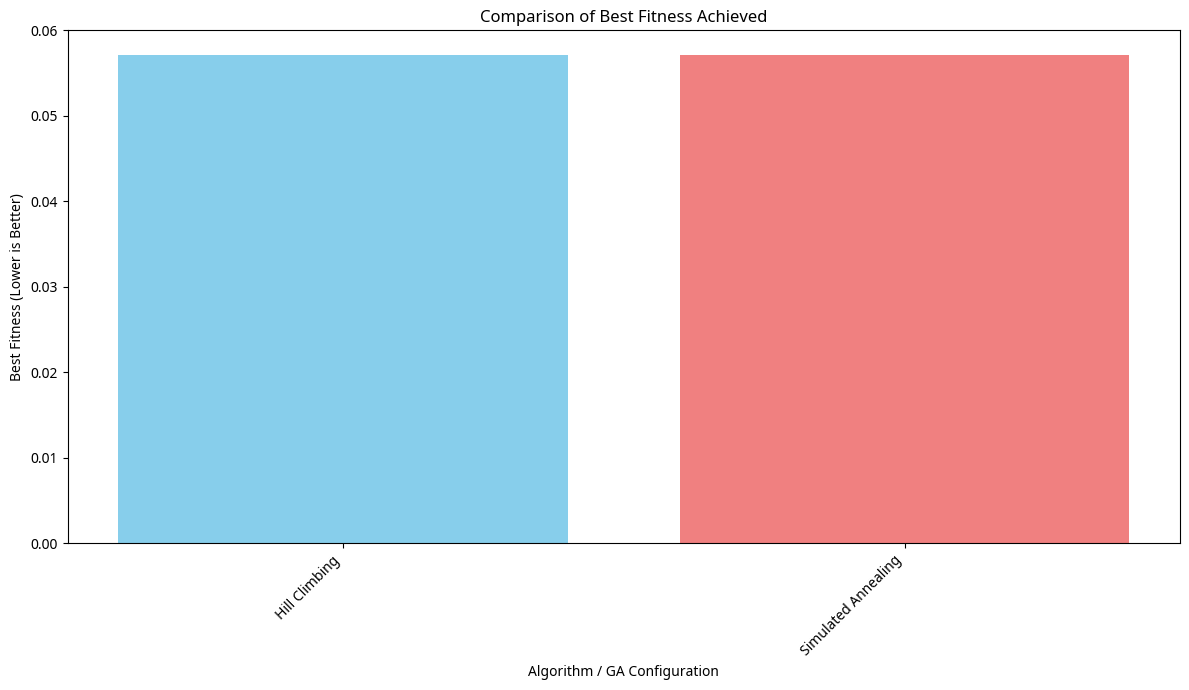

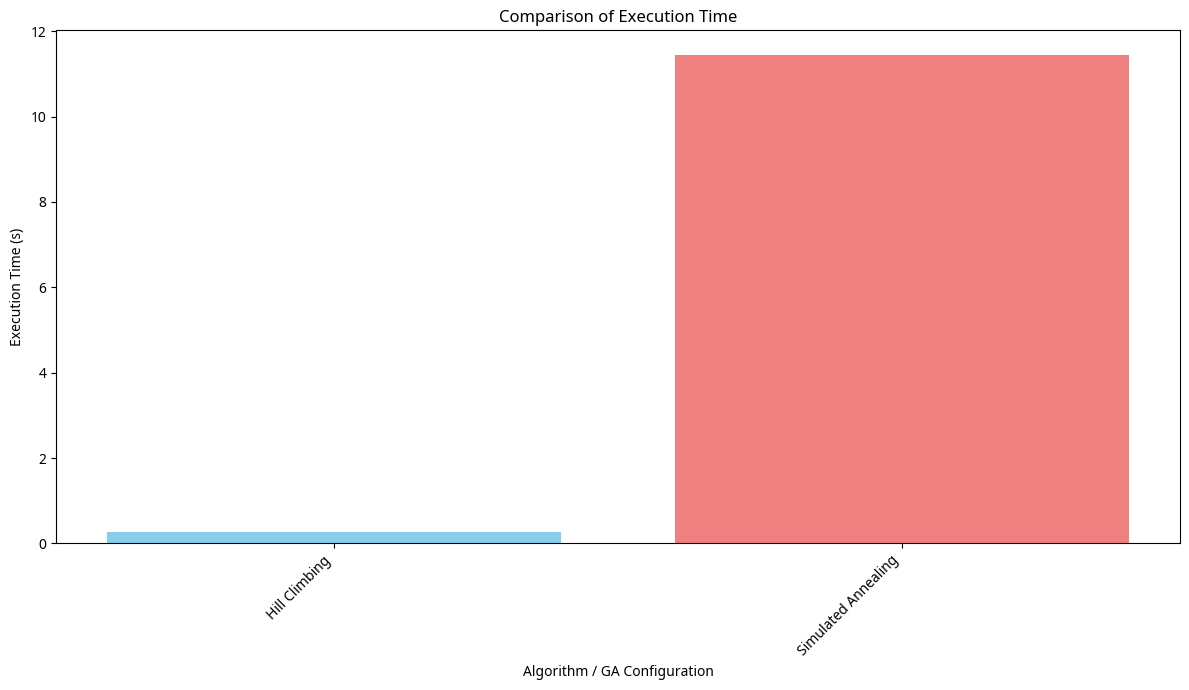

In [7]:
# Plotting Best Fitness
plt.figure(figsize=(12, 7))
# Sort by best fitness for clearer visualization
comparison_df_sorted_fitness = comparison_df.sort_values(by="Best Fitness", ascending=True)
plt.bar(comparison_df_sorted_fitness["Algorithm"], comparison_df_sorted_fitness["Best Fitness"], color=["skyblue", "lightcoral"] + ["lightgreen"]*(len(comparison_df_sorted_fitness)-2) if len(comparison_df_sorted_fitness)>2 else ["skyblue", "lightcoral"])
plt.xlabel("Algorithm / GA Configuration")
plt.ylabel("Best Fitness (Lower is Better)")
plt.title("Comparison of Best Fitness Achieved")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# Plotting Execution Time
plt.figure(figsize=(12, 7))
comparison_df_sorted_time = comparison_df.sort_values(by="Execution Time (s)", ascending=True)
plt.bar(comparison_df_sorted_time["Algorithm"], comparison_df_sorted_time["Execution Time (s)"], color=["skyblue", "lightcoral"] + ["lightgreen"]*(len(comparison_df_sorted_time)-2) if len(comparison_df_sorted_time)>2 else ["skyblue", "lightcoral"])
plt.xlabel("Algorithm / GA Configuration")
plt.ylabel("Execution Time (s)")
plt.title("Comparison of Execution Time")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

## 5. Discussion of Results

*This section will be filled in after observing the results from the comparative analysis.*

- **Hill Climbing:** (Observations about its performance, speed, tendency to get stuck in local optima)
- **Simulated Annealing:** (Observations about its performance, ability to escape local optima, sensitivity to parameters like temperature schedule)
- **Genetic Algorithm Configurations:**
    - Which GA configuration performed best in terms of fitness?
    - Which GA configuration was fastest?
    - How did the different mutation, crossover, and selection operators affect performance?
    - Were the new/adapted operators effective?
- **Overall Comparison:** Which algorithm(s) seem most promising for this problem and why?
- **Limitations and Future Work:** (Any limitations of the current study, ideas for further improvements or experiments)

## 6. Conclusion

*This section will summarize the key findings of the project and the effectiveness of the implemented algorithms for the Sports League Assignment Problem.*

In [8]:
print("Notebook execution completed.")

Notebook execution completed.
